# Scale, Standardize, or Normalize with scikit-learn
## When to use MinMaxScaler, RobustScaler, StandardScaler, and Normalizer
## By Jeff Hale

## Please upvote if you find this Kernel helpful :)

# Why scale, standardize, or normalize?

Many machine learning algorithms, such as neural networks, regression-based algorithms, K-nearest neighbors, support vector machines with radial bias kernel functions, principal components analysis, and algorithms using linear discriminant analysis don't perform as well if the features are not on relatively similar scales. 

Sometimes you'll want a more normally distributed distribution. 

Some of the methods below dilute the effects of outliers. 

## TLDR

* Use MinMaxScaler as your default
* Use RobustScaler if you have outliers and can handle a larger range
* Use StandardScaler if you need normalized features
* Use Normalizer sparingly - it normalizes rows, not columns

Here's a [cheat sheet I made in a google sheet](https://docs.google.com/spreadsheets/d/1woVi7wq13628HJ-tN6ApaRGVZ85OdmHsDBKLAf5ylaQ/edit?usp=sharing) to help folks keep the options straight. 

Let's set things up and start making some distributions!

In [1]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.style.use('ggplot')

np.random.seed(34)

# Original Distributions

Let's make several types of random distributions.

In [2]:
#create columns of various distributions
df = pd.DataFrame({ 
    'beta': np.random.beta(5, 1, 1000) * 60,        # beta
    'exponential': np.random.exponential(10, 1000), # exponential
    'normal_p': np.random.normal(10, 2, 1000),      # normal platykurtic
    'normal_l': np.random.normal(10, 10, 1000),     # normal leptokurtic
})

# make bimodal distribution
first_half = np.random.normal(20, 3, 500) 
second_half = np.random.normal(-20, 3, 500) 
bimodal = np.concatenate([first_half, second_half])

df['bimodal'] = bimodal

# create list of column names to use later
col_names = list(df.columns)

Let's plot our original distributions.

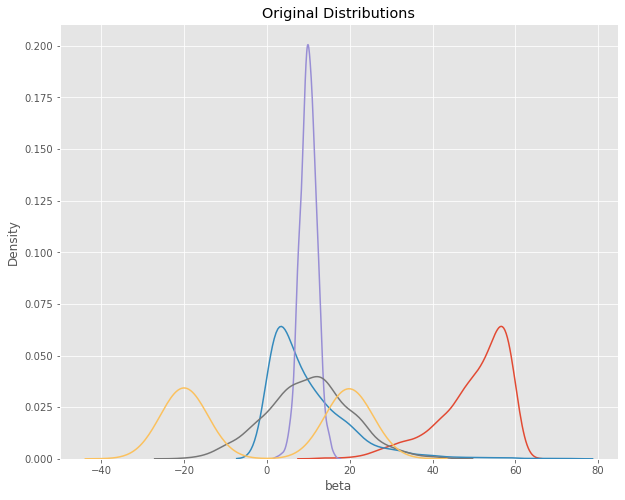

In [3]:
# plot original distribution plot
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

sns.kdeplot(df['beta'], ax=ax1)
sns.kdeplot(df['exponential'], ax=ax1)
sns.kdeplot(df['normal_p'], ax=ax1)
sns.kdeplot(df['normal_l'], ax=ax1)
sns.kdeplot(df['bimodal'], ax=ax1);

In [4]:
df.head()

,beta,exponential,normal_p,normal_l,bimodal
0,39.273740,2.263890,11.860245,4.748207,19.496627
1,55.030395,13.108592,11.796582,10.959172,16.871186
2,47.434682,3.312019,11.146945,3.919227,12.655741
3,43.173536,17.664301,8.266689,42.072915,18.657904
4,45.681443,2.109760,5.112983,16.960664,22.646439


Let's see what are the means are.

In [5]:
df.mean()

beta           50.024249
exponential    10.028387
normal_p        9.994006
normal_l       10.175745
bimodal        -0.076622
dtype: float64

If you'd like more summary statistics:

In [6]:
df.describe()

,beta,exponential,normal_p,normal_l,bimodal
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,50.024249,10.028387,9.994006,10.175745,-0.076622
std,8.474545,9.733928,2.013971,10.104004,20.165208
min,13.854022,0.007617,2.356844,-19.539980,-28.709856
25%,45.793283,2.951421,8.687478,3.566822,-19.995311
50%,52.337504,7.018565,9.983498,10.326331,0.237049
75%,56.722191,14.022485,11.306914,16.615057,19.891202
max,59.990640,71.344341,16.214364,42.072915,28.252151


<AxesSubplot:>

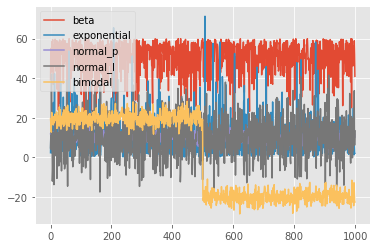

In [7]:
df.plot()

These values are all in the same ballpark.

## Add a feature with much larger values

This feature could be home prices, for example.

In [8]:
normal_big = np.random.normal(1000000, 10000, (1000,1))  # normal distribution of large values
df['normal_big'] = normal_big

In [9]:
col_names.append('normal_big')

<AxesSubplot:ylabel='Density'>

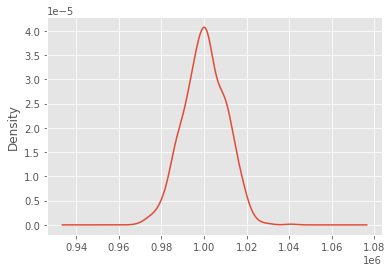

In [10]:
df['normal_big'].plot(kind='kde')

In [11]:
df.normal_big.mean()

1000258.7226640374

We've got a normalish distribution with a mean near 1,000,0000.

If we put this on the same plot as the original distributions, you can't even see the earlier columns.

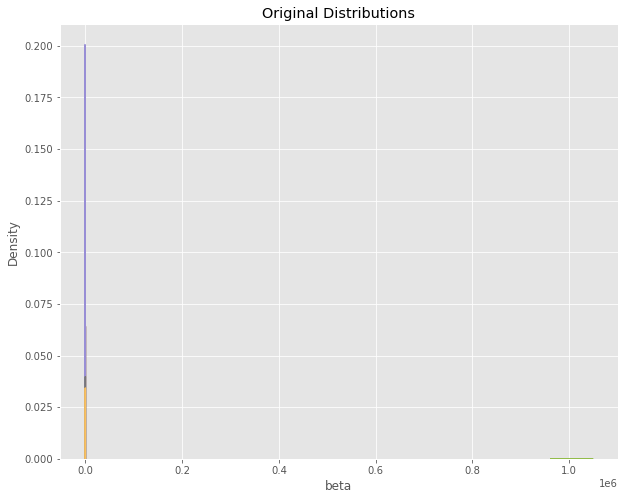

In [12]:
# plot original distribution plot with larger value feature
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

sns.kdeplot(df['beta'], ax=ax1)
sns.kdeplot(df['exponential'], ax=ax1)
sns.kdeplot(df['normal_p'], ax=ax1)
sns.kdeplot(df['normal_l'], ax=ax1)
sns.kdeplot(df['bimodal'], ax=ax1);
sns.kdeplot(df['normal_big'], ax=ax1);

The new, high-value distribution is way to the right. And here's a plot of the values.

<AxesSubplot:>

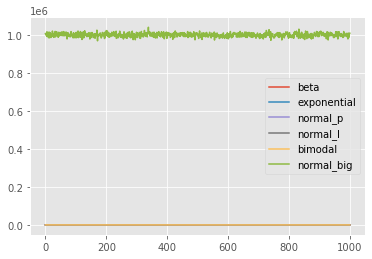

In [13]:
df.plot()

In [14]:
df.describe()

,beta,exponential,normal_p,normal_l,bimodal,normal_big
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,50.024249,10.028387,9.994006,10.175745,-0.076622,1.000259e+06
std,8.474545,9.733928,2.013971,10.104004,20.165208,9.935564e+03
min,13.854022,0.007617,2.356844,-19.539980,-28.709856,9.692079e+05
25%,45.793283,2.951421,8.687478,3.566822,-19.995311,9.936191e+05
50%,52.337504,7.018565,9.983498,10.326331,0.237049,1.000241e+06
75%,56.722191,14.022485,11.306914,16.615057,19.891202,1.007335e+06
max,59.990640,71.344341,16.214364,42.072915,28.252151,1.040677e+06


Now let's see what happens when we do some scaling. Let's apply MinMax Scaler first.

# MinMaxScaler 

MinMaxScaler subtracts the column mean from each value and then divides by the range.

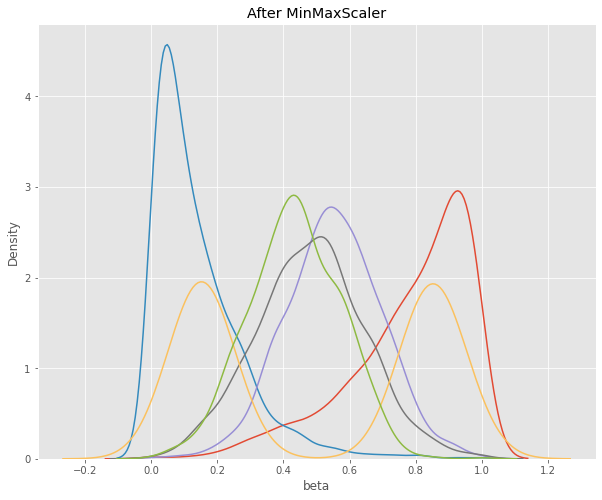

In [15]:
mm_scaler = preprocessing.MinMaxScaler()
df_mm = mm_scaler.fit_transform(df)

df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After MinMaxScaler')

sns.kdeplot(df_mm['beta'], ax=ax1)
sns.kdeplot(df_mm['exponential'], ax=ax1)
sns.kdeplot(df_mm['normal_p'], ax=ax1)
sns.kdeplot(df_mm['normal_l'], ax=ax1)
sns.kdeplot(df_mm['bimodal'], ax=ax1)
sns.kdeplot(df_mm['normal_big'], ax=ax1);

Notice how the shape of each distribution remains the same, but now the values are between 0 and 1.

In [16]:
df_mm['beta'].min()

0.0

In [17]:
df_mm['beta'].max()

1.0

Let's look at the minimums and maximums for each column prior to scaling.

In [18]:
mins = [df[col].min() for col in df.columns]
mins

[13.854021608409585,
 0.007616647999640711,
 2.356844136010337,
 -19.539980266046484,
 -28.709856256186555,
 969207.9390261483]

In [19]:
maxs = [df[col].max() for col in df.columns]
maxs

[59.99064035594787,
 71.3443406149087,
 16.214363985744633,
 42.07291533170829,
 28.252151215165426,
 1040677.4560143511]

Let's check the minimums and maximums for each column after MinMaxScaler.

In [20]:
mins = [df_mm[col].min() for col in df_mm.columns]
mins

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
maxs = [df_mm[col].max() for col in df_mm.columns]
maxs

[1.0, 1.0, 1.0000000000000002, 0.9999999999999999, 1.0, 1.0]

Looks close enough to 0 to 1 intervals to me. Our feature with much larger values was brought into scale with our other features. 

Now let's look at RobustScaler.

# RobustScaler

RobustScaler subtracts the column median and divides by the interquartile range.

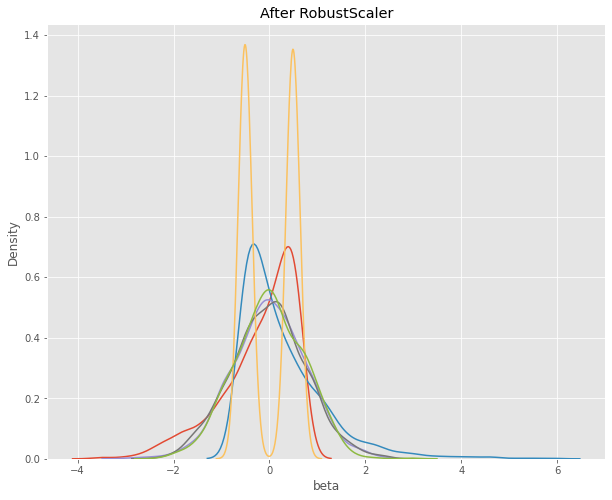

In [22]:
r_scaler = preprocessing.RobustScaler()
df_r = r_scaler.fit_transform(df)

df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After RobustScaler')

sns.kdeplot(df_r['beta'], ax=ax1)
sns.kdeplot(df_r['exponential'], ax=ax1)
sns.kdeplot(df_r['normal_p'], ax=ax1)
sns.kdeplot(df_r['normal_l'], ax=ax1)
sns.kdeplot(df_r['bimodal'], ax=ax1)
sns.kdeplot(df_r['normal_big'], ax=ax1);

Let's check the minimums and maximums for each column after RobustScaler.

In [23]:
mins = [df_r[col].min() for col in df_r.columns]
mins

[-3.521256013025104,
 -0.6332678488395711,
 -2.91156392760608,
 -2.2889157521406003,
 -0.7257316470250651,
 -2.2626655321281044]

In [24]:
maxs = [df_r[col].max() for col in df_r.columns]
maxs

[0.700265390227522,
 5.810261462820452,
 2.3787055278781155,
 2.433017414912012,
 0.7023702913932945,
 2.9482173719311544]

Although the range of values for each feature is much smaller than for the original features, it's larger and varies more than for MinMaxScaler. The bimodal distribution values are now compressed into two small groups.

Now let's look at StandardScaler.

# StandardScaler

StandardScaler is scales each column to have 0 mean and unit variance.

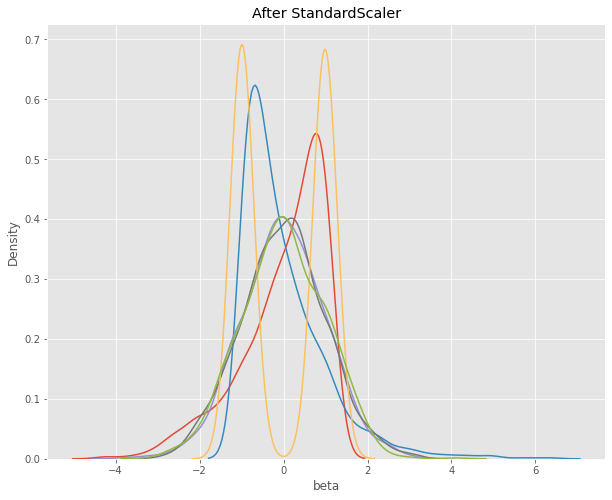

In [25]:
s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(df)

df_s = pd.DataFrame(df_s, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After StandardScaler')

sns.kdeplot(df_s['beta'], ax=ax1)
sns.kdeplot(df_s['exponential'], ax=ax1)
sns.kdeplot(df_s['normal_p'], ax=ax1)
sns.kdeplot(df_s['normal_l'], ax=ax1)
sns.kdeplot(df_s['bimodal'], ax=ax1)
sns.kdeplot(df_s['normal_big'], ax=ax1);

Qutie a nice chart, don't you think? You can see that all features now have 0 mean.

Let's check the minimums and maximums for each column after StandardScaler.

In [26]:
mins = [df_s[col].min() for col in df_s.columns]
mins

[-4.270238356986723,
 -1.0299834064894655,
 -3.7939883106225425,
 -2.9424568517799368,
 -1.4206429830609901,
 -3.126779701794258]

In [27]:
maxs = [df_s[col].max() for col in df_s.columns]
maxs

[1.1766269856411702,
 6.302351061844018,
 3.0901485502210164,
 3.158463886242835,
 1.4055370928053141,
 4.070121916594157]

The ranges are fairly similar to RobustScaler. 

Now let's look at Normalizer.

# Normalizer

Note that normalizer operates on the rows, not the columns. It applies l2 normalization by default.

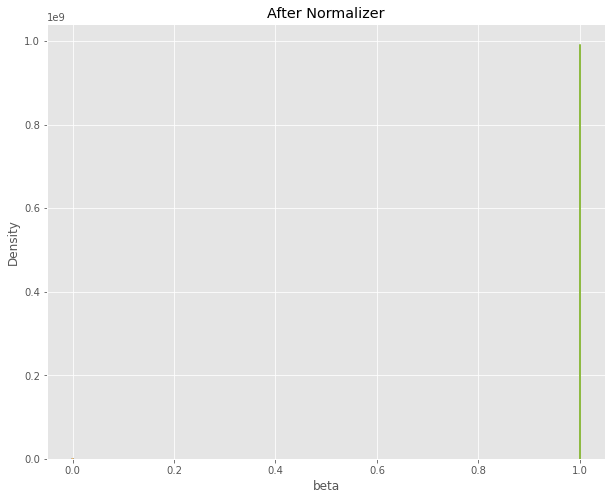

In [28]:
n_scaler = preprocessing.Normalizer()
df_n = n_scaler.fit_transform(df)

df_n = pd.DataFrame(df_n, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After Normalizer')

sns.kdeplot(df_n['beta'], ax=ax1)
sns.kdeplot(df_n['exponential'], ax=ax1)
sns.kdeplot(df_n['normal_p'], ax=ax1)
sns.kdeplot(df_n['normal_l'], ax=ax1)
sns.kdeplot(df_n['bimodal'], ax=ax1)
sns.kdeplot(df_n['normal_big'], ax=ax1);

Let's check the minimums and maximums for each column after scaling.

In [29]:
mins = [df_n[col].min() for col in df_n.columns]
mins

[1.3827732328245718e-05,
 7.506766221580962e-09,
 2.3413976491231327e-06,
 -1.9569177313577106e-05,
 -2.8641556621580004e-05,
 0.9999999959175602]

In [30]:
maxs = [df_n[col].max() for col in df_n.columns]
maxs

[6.0917225507124665e-05,
 7.142164283270129e-05,
 1.6544412294111953e-05,
 4.190267415662595e-05,
 2.8265467956698925e-05,
 0.9999999995621566]

Normalizer also moved the features to similar scales. Notice that the range for our much larger feature's values is now extremely small and clustered around .9999999999. 

Let's look at our original and transformed distributions together. We'll exclude Normalizer because you generally want to tranform your features, not your samples.

# Combined Plot

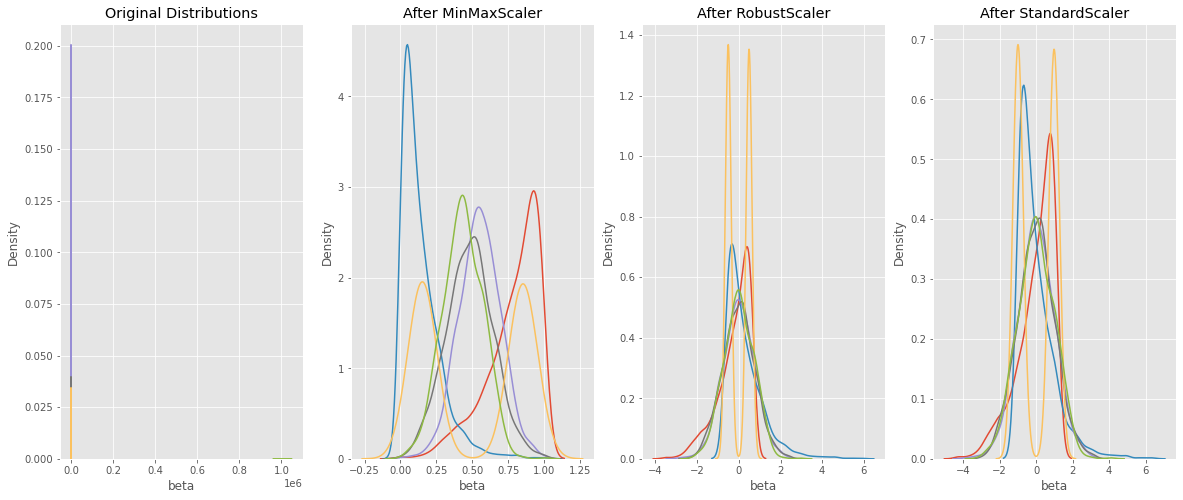

In [31]:
# Combined plot.

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20, 8))


ax0.set_title('Original Distributions')

sns.kdeplot(df['beta'], ax=ax0)
sns.kdeplot(df['exponential'], ax=ax0)
sns.kdeplot(df['normal_p'], ax=ax0)
sns.kdeplot(df['normal_l'], ax=ax0)
sns.kdeplot(df['bimodal'], ax=ax0)
sns.kdeplot(df['normal_big'], ax=ax0);


ax1.set_title('After MinMaxScaler')

sns.kdeplot(df_mm['beta'], ax=ax1)
sns.kdeplot(df_mm['exponential'], ax=ax1)
sns.kdeplot(df_mm['normal_p'], ax=ax1)
sns.kdeplot(df_mm['normal_l'], ax=ax1)
sns.kdeplot(df_mm['bimodal'], ax=ax1)
sns.kdeplot(df_mm['normal_big'], ax=ax1);


ax2.set_title('After RobustScaler')

sns.kdeplot(df_r['beta'], ax=ax2)
sns.kdeplot(df_r['exponential'], ax=ax2)
sns.kdeplot(df_r['normal_p'], ax=ax2)
sns.kdeplot(df_r['normal_l'], ax=ax2)
sns.kdeplot(df_r['bimodal'], ax=ax2)
sns.kdeplot(df_r['normal_big'], ax=ax2);


ax3.set_title('After StandardScaler')

sns.kdeplot(df_s['beta'], ax=ax3)
sns.kdeplot(df_s['exponential'], ax=ax3)
sns.kdeplot(df_s['normal_p'], ax=ax3)
sns.kdeplot(df_s['normal_l'], ax=ax3)
sns.kdeplot(df_s['bimodal'], ax=ax3)
sns.kdeplot(df_s['normal_big'], ax=ax3);

You can see that after any transformation the distributions are on a similar scale. Also notice that MinMaxScaler doesn't distort the distances between the values in each feature.

I hope you found this Kernel to be a helpful introduction to Scaling, Standardizing, and Normalizing with scikit-learn. Please upvote it if you found it helpful!